In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, scale
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score

from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

from IPython.display import Markdown, display
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

pip install 'aif360[AdversarialDebiasing]'


### Read modelling dataset

In [2]:
dataset = pd.read_csv('../../data/modelling-dataset.csv')

In [3]:
dataset.iloc[:,0]

0          863.97
1          828.63
2         1000.59
3          700.42
4          505.92
           ...   
181897    1949.28
181898    2096.72
181899    2134.48
181900    2538.29
181901    3799.74
Name: current_premium, Length: 181902, dtype: float64

In [4]:
orig_dataset = BinaryLabelDataset(df=dataset, label_names=['risk_group'],
                                  protected_attribute_names=['male', 'middle-aged', 'ypc_1', 'minority'],
                                  favorable_label=0, unfavorable_label=1)

In [5]:
# check whether it's resampled
df_og = orig_dataset.convert_to_dataframe()[0]
df_og['risk_group'].value_counts()

1.0    90951
0.0    90951
Name: risk_group, dtype: int64

In [6]:
# 70:30 split into train, test
# 50:50 split of test into valid, test
dataset_train, dataset_vt = orig_dataset.split([0.7], shuffle=True)
dataset_valid, dataset_test = dataset_vt.split([0.5], shuffle=True)

### Modelling: Decision Tree, Random Forests

#### Train

#### Decision Tree vs Random Forest

In [8]:
# setup training data
X_train = dataset_train.features
y_train = dataset_train.labels.ravel()
w_train = dataset_train.instance_weights.ravel()

# train decision tree
tree = DecisionTreeClassifier(random_state=786).fit(X_train, y_train)
tree_y_train_pred = tree.predict(X_train)

# train random forest
forest = RandomForestClassifier(random_state=786).fit(X_train, y_train)
forest_y_train_pred = forest.predict(X_train)

In [9]:
# no improvement in going to random forest
(tree_y_train_pred == y_train).sum()/len(y_train), (forest_y_train_pred == y_train).sum()/len(y_train)

(0.9999371716235638, 0.9999293180765093)

In [10]:
# plt.figure(figsize=(8,10))
# plot_tree(tree, filled=True, fontsize=10, feature_names=orig_dataset.feature_names,
#          class_names=['low_risk_group', 'high_risk_group'])
# plt.show()

In [11]:
# fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20,2))

# for n in range(0,10):
#     plot_tree(forest[n], filled=True, feature_names=orig_dataset.feature_names,
#               class_names=['low_risk_group', 'high_risk_group'], ax=axes[n])

# plt.show()

In [12]:
# dataset_train --> dataset_train_pred
dataset_train_pred = dataset_train.copy()
dataset_train_pred.labels = tree_y_train_pred

#### Valid

In [15]:
# dataset_valid --> dataset_valid_pred
dataset_valid_pred = dataset_valid.copy(deepcopy=True)
X_valid = dataset_valid_pred.features
y_valid = dataset_valid_pred.labels

# get preds for obs being in risk group 1
# NOTE: tree probabilities are 0s or 1s
pos_ind = 1
dataset_valid_pred.scores = tree.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)
tree_y_valid_pred = dataset_valid_pred.scores

In [18]:
# NOTE: doesn't work with floats, so need to convert into int values (not int arr)
accuracy_score(y_valid.astype(int), tree_y_valid_pred.astype(int))

0.9895547003848268

#### Test

In [16]:
# dataset_test --> dataset_test_pred
dataset_test_pred = dataset_test.copy(deepcopy=True)
X_test = dataset_test_pred.features
y_test = dataset_test_pred.labels

# get preds for obs being in risk group 1
pos_ind = 1
dataset_test_pred.scores = tree.predict_proba(X_test)[:,pos_ind].reshape(-1,1)
tree_y_test_pred = dataset_test_pred.scores

In [17]:
# NOTE: doesn't work with floats, so need to convert into int values (not int arr)
accuracy_score(y_test.astype(int), tree_y_test_pred.astype(int))

0.988162427618559

### Optimize n_estimators, max_features, max_impurity, min_impurity_split

In [19]:
len(orig_dataset.feature_names)

15

In [20]:
list_of_params = {
    'max_depth': {'start': 1, 'stop': 151, 'step': 5},
    'min_impurity_split': {'start': 0.21, 'stop': 0.001, 'step': -0.001},
    'max_features': {'start': 1, 'stop': len(orig_dataset.feature_names), 'step': 1},
    'min_impurity_decrease': {'start': 0.51, 'stop': 0.01, 'step': -0.01}
}

In [46]:
for param in list_of_params.keys():
    start = list_of_params[param]['start']
    stop = list_of_params[param]['stop']
    step = list_of_params[param]['step']
    
    param_arr = np.arange(start, stop, step)
    n_samples = np.int(round((stop-start)/step, 0))
    
    print("Tuning %s" %param)
    
    if param == 'max_depth':    
        ba_arr_depth = np.zeros(n_samples)
        param_arr_depth = np.zeros(n_samples)
        depth_arr_depth = np.zeros(n_samples)
        
        for idx, val in tqdm(enumerate(param_arr)):
            new_tree = DecisionTreeClassifier(max_depth=val).fit(X_train, y_train)
            new_tree_y_valid_pred = new_tree.predict(X_valid).reshape(-1,1)

            ba_arr_depth[idx], param_arr_depth[idx], depth_arr_depth[idx] = balanced_accuracy_score(y_valid, new_tree_y_valid_pred), val, new_tree.get_depth()

    elif param == 'min_impurity_split':
        ba_arr_imp_split = np.zeros(n_samples)
        param_arr_imp_split = np.zeros(n_samples)
        depth_arr_imp_split = np.zeros(n_samples)

        for idx, val in tqdm(enumerate(param_arr)):
            new_tree = DecisionTreeClassifier(min_impurity_split=val).fit(X_train, y_train)
            new_tree_y_valid_pred = new_tree.predict(X_valid).reshape(-1,1)

            ba_arr_imp_split[idx], param_arr_imp_split[idx], depth_arr_imp_split[idx] = balanced_accuracy_score(y_valid, new_tree_y_valid_pred), val, new_tree.get_depth()

    elif param == 'max_features':
        ba_arr_features = np.zeros(n_samples)
        param_arr_features = np.zeros(n_samples)
        depth_arr_features = np.zeros(n_samples)

        for idx, val in tqdm(enumerate(param_arr)):
            new_tree = DecisionTreeClassifier(max_features=val).fit(X_train, y_train)
            new_tree_y_valid_pred = new_tree.predict(X_valid).reshape(-1,1)

            ba_arr_features[idx], param_arr_features[idx], depth_arr_features[idx] = balanced_accuracy_score(y_valid, new_tree_y_valid_pred), val, new_tree.get_depth()

    elif param == 'min_impurity_decrease':
        ba_arr_imp_dec = np.zeros(n_samples)
        param_arr_imp_dec = np.zeros(n_samples)
        depth_arr_imp_dec = np.zeros(n_samples)

        for idx, val in tqdm(enumerate(param_arr)):
            new_tree = DecisionTreeClassifier(min_impurity_decrease=val).fit(X_train, y_train)
            new_tree_y_valid_pred = new_tree.predict(X_valid).reshape(-1,1)

            ba_arr_imp_dec[idx], param_arr_imp_dec[idx], depth_arr_imp_dec[idx] = balanced_accuracy_score(y_valid, new_tree_y_valid_pred), val, new_tree.get_depth()
            
            

1it [00:00,  7.85it/s]

Tuning max_depth


30it [00:15,  1.98it/s]
1it [00:00,  9.92it/s]

Tuning min_impurity_split


209it [00:52,  3.98it/s]
1it [00:00,  5.37it/s]

Tuning max_features


14it [00:03,  3.61it/s]
1it [00:00,  9.81it/s]

Tuning min_impurity_decrease


50it [00:06,  7.53it/s]


### Visualize 

In [22]:
sns.set()

In [23]:
def plot_tree_arr(parameter_arr, accuracy_arr, metric_arr, param, metric_name=None):
    if metric_name == None:
        metric_name = 'Tree Depth'
    
    fig, ax1 = plt.subplots(figsize=(8,6))

    ax1.plot(parameter_arr, accuracy_arr, c='tab:orange')
    ax1.set_ylim([0.49,1.01])
    ax1.set_xlabel(param, fontsize=14)
    ax1.set_ylabel('Balanced Accuracy', fontsize=14, c='tab:orange')
    ax1.set_title('Relationship between %s and Balanced Accuracy \n and %s' % (param, metric_name), size=14)

    ax2 = plt.twinx()
    ax2.plot(parameter_arr, metric_arr, c='tab:blue')
    ax2.set_ylabel(metric_name, c='tab:blue', fontsize=14, rotation=-90, labelpad=15)
    
    plt.show()

#### Decision Tree

In [47]:
plt.plot(param_arr_depth, ba_arr_depth)
plt.title('Effect of Tree Depth on Balanced Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Balanced Acccuracy')
plt.show()

In [48]:
best_depth = param_arr_depth[np.where(ba_arr_depth == np.max(ba_arr_depth))[0][0]]

In [49]:
print("Balanced Accuracy is maximized at a tree depth of %s. However, so many trees may lead to overfitting, \nespecially since most of the splits are on one feature, current_premium." % best_depth)



Balanced Accuracy is maximized at a tree depth of 76.0. However, so many trees may lead to overfitting, 
especially since most of the splits are on one feature, current_premium.


In [50]:
plot_tree_arr(param_arr_imp_split, ba_arr_imp_split, depth_arr_imp_split, param='min_impurity_split')

In [51]:
upper_imp_split = param_arr_imp_split[np.where(depth_arr_imp_split == 68)[0][-1]]

In [52]:
lower_imp_split = param_arr_imp_split[np.where(depth_arr_imp_split == 1)[0][-1]]

In [53]:
print("When min_impurity_split <= %f, there are too many splits leading to overfitting. When min_impurity_split > %f, there are too few splits leading to underfitting. Hence, the optimal value for min_impurity_split lies between these two values" %(upper_imp_split, lower_imp_split))



When min_impurity_split <= 0.018000, there are too many splits leading to overfitting. When min_impurity_split > 0.112000, there are too few splits leading to underfitting. Hence, the optimal value for min_impurity_split lies between these two values


In [54]:
plot_tree_arr(param_arr_features, ba_arr_features, depth_arr_features, param='max_features')

In [55]:
# only the first feature, current_premium, is predictive of the target variable, risk_group
tree.feature_importances_[0]

0.9724697012666247

In [56]:
print("Increasing the number of max_features does not affect Balanced Accuracy. That is because only one feature, current_premium, is predictive of the target variable, risk_group, according to the decision tree algorithm.")



Increasing the number of max_features does not affect Balanced Accuracy. That is because only one feature, current_premium, is predictive of the target variable, risk_group, according to the decision tree algorithm.


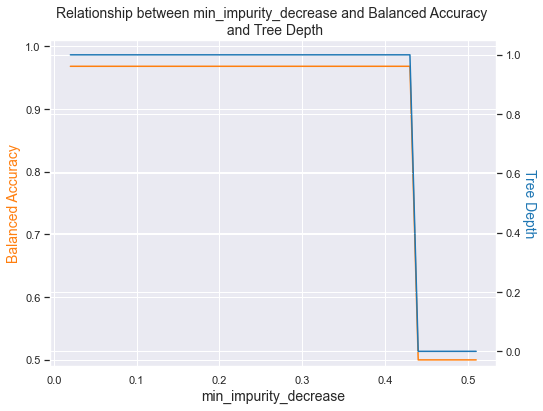

In [57]:
plot_tree_arr(param_arr_imp_dec, ba_arr_imp_dec, depth_arr_imp_dec, param='min_impurity_decrease')

In [58]:
upper_imp_dec = param_arr_imp_dec[np.where(ba_arr_imp_dec == 0.5)[0][-1]+1]

In [59]:
print("A min_impurity_decrease < %f maximizes Balanced Accuracy." % upper_imp_dec)

A min_impurity_decrease < 0.430000 maximizes Balanced Accuracy.


#### Random Forest

In [60]:
param = 'n_estimators'

# set start, stop, step
start = 1
stop = 101
step = 10

n_samples = np.int(round((stop-start)/step, 0))
print(n_samples)

param_arr_est = np.arange(start, stop, step)
ba_arr_est = np.zeros(n_samples)
depth_arr_est = np.zeros(n_samples)

for idx, val in tqdm(enumerate(param_arr_est)):    
    new_forest = RandomForestClassifier(n_estimators=val).fit(X_train, y_train)
    new_forest_y_valid_pred = new_forest.predict(X_valid)
    
    ba_arr_est[idx], param_arr_est[idx], depth_arr_est[idx] = balanced_accuracy_score(y_valid, new_forest_y_valid_pred), val, len(new_forest.estimators_)
    
    

1it [00:00,  5.51it/s]

10


10it [00:51,  5.15s/it]


In [61]:
plt.plot(param_arr_est, ba_arr_est)
plt.title('Effect of n_estimators on Balanced Accuracy')
plt.ylim([0.45,1.05])
plt.xlabel('n_estimators')
plt.ylabel('Balanced Acccuracy')
plt.show()

In [62]:
print("Similar to max_features, n_estimators has no effect on Balanced Accuracy.")

Similar to max_features, n_estimators has no effect on Balanced Accuracy.


### Compute fairness metrics at different values for max_depth

In [63]:
# privileged_groups = [{'male': 0}]
# unprivileged_groups = [{'male': 1}]

privileged_groups = [{'male': 0, 'middle-aged': 0, 'minority': 0, 'ypc_1': 0}]
unprivileged_groups = [{'male': 1, 'middle-aged': 1, 'minority': 1, 'ypc_1': 1}]

# select dataset
d1 = dataset_test
d2 = dataset_test_pred

In [64]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr = []
mean_diff_arr = []
avg_odds_arr = []
disp_imp_arr = []
indiv_fair_arr = []

# needs to be same for original and transformed datasets
param_arr = [1,10,20,30,40,50,60,70,80,90,100,110,120]

for param in tqdm(param_arr):
    # fit a new decision tree
    new_tree = DecisionTreeClassifier(max_depth=param).fit(X_train, y_train)
    new_tree_y_test_pred = new_tree.predict(X_test).reshape(-1,1)
    # update predictions
    d2.labels = new_tree_y_test_pred
    
    metrics_test = ClassificationMetric(d1, d2,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
    
    bal_acc = 0.5*(metrics_test.true_positive_rate()+metrics_test.true_negative_rate())
    bal_acc_arr.append(bal_acc)
    
    mean_diff_arr.append(metrics_test.mean_difference())    
    avg_odds_arr.append(metrics_test.average_odds_difference())
    disp_imp_arr.append(metrics_test.disparate_impact())
    indiv_fair_arr.append(metrics_test.consistency(n_neighbors=5))

#### Predictions from original testing data

100%|██████████| 13/13 [00:16<00:00,  1.24s/it]


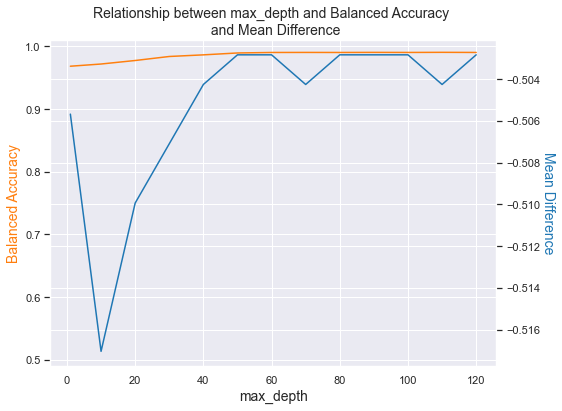

In [65]:
plot_tree_arr(param_arr, bal_acc_arr, mean_diff_arr, param='max_depth', metric_name='Mean Difference')

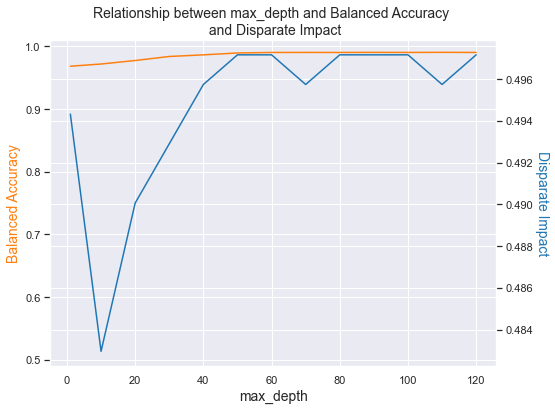

In [66]:
plot_tree_arr(param_arr, bal_acc_arr, disp_imp_arr, param='max_depth', metric_name='Disparate Impact')

### Train on transformed data

In [72]:
dataset_transf = pd.read_csv('../../data/allstate-transformed.csv')

In [73]:
dataset_transf = BinaryLabelDataset(df=dataset_transf, label_names=['risk_group'], 
                             protected_attribute_names=['male', 'middle-aged', 'ypc_1', 'minority'],
                             favorable_label=0, unfavorable_label=1)

In [74]:
# 70:30 split into train, test
# 50:50 split of test into valid, test
dataset_transf_train, dataset_transf_test = dataset_transf.split([0.7], shuffle=True)
# dataset_transf_valid, dataset_transf_test = dataset_transf_vt.split([0.5], shuffle=True)

#### Train

In [75]:
X_train_transf = dataset_transf_train.features
y_train_transf = dataset_transf_train.labels.ravel()
w_train_transf = dataset_transf_train.instance_weights.ravel()

tree_transf = DecisionTreeClassifier(random_state=786).fit(X_train, y_train)
tree_y_train_pred = tree_transf.predict(X_train)

#### Test

In [76]:
dataset_transf_test_pred = dataset_transf_test.copy(deepcopy=True)

X_test_transf = dataset_transf_test_pred.features
y_test_transf = dataset_transf_test_pred.labels

# prob of predicting obs to be in risk group 1
pos_ind = 1
dataset_transf_test_pred.scores = tree_transf.predict_proba(X_test_transf)[:,pos_ind].reshape(-1,1)
y_test_preds_transf = dataset_transf_test_pred.scores

In [77]:
# select dataset
d1 = dataset_transf_test
d2 = dataset_transf_test_pred

In [78]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
mean_diff_arr_transf = []
avg_odds_arr_transf = []
disp_imp_arr_transf = []
indiv_fair_arr_transf = []

for param in tqdm(param_arr):
    # fit a new decision tree
    new_tree = DecisionTreeClassifier(max_depth=param).fit(X_train_transf, y_train_transf)
    new_tree_y_test_pred_transf = new_tree.predict(X_test_transf).reshape(-1,1)
    # update predictions
    d2.labels = new_tree_y_test_pred_transf
    
    metrics_test = ClassificationMetric(d1, d2,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
    
    bal_acc = 0.5*(metrics_test.true_positive_rate()+metrics_test.true_negative_rate())
    bal_acc_arr_transf.append(bal_acc)
    
    mean_diff_arr_transf.append(metrics_test.mean_difference())    
    avg_odds_arr_transf.append(metrics_test.average_odds_difference())
    disp_imp_arr_transf.append(metrics_test.disparate_impact())
    indiv_fair_arr_transf.append(metrics_test.consistency(n_neighbors=5))

#### Predictions from transformed testing data

100%|██████████| 13/13 [00:17<00:00,  1.34s/it]


### Visualize tradeoffs

In [79]:
def plot_tradeoffs(thresholds_array, accuracy_array, fairness_array, transformed_fairness_array, ax, name):
    ax.plot(thresholds_array, accuracy_array)
    ax.set_xlabel('Decision Tree Depth', fontsize=10.5)
    ax.set_ylabel('Balanced Accuracy', color='b', fontsize=12, labelpad=15)
    # best_class_thresh used as global variable
    # ax.axvline(best_class_thresh, color='k', linestyle=':')

    ax1 = ax.twinx()
    ax1.plot(thresholds_array, fairness_array, color='r', alpha=0.5)
    ax1.set_ylabel(name, color='r', fontsize=12, rotation=-90, labelpad=15)
    ax1.plot(thresholds_array, transformed_fairness_array, color='r')
    
    ax.set_title(name, fontsize=16)
    ax1.legend(['Original', 'Transformed'], loc='lower left')
    ax1.grid(True)

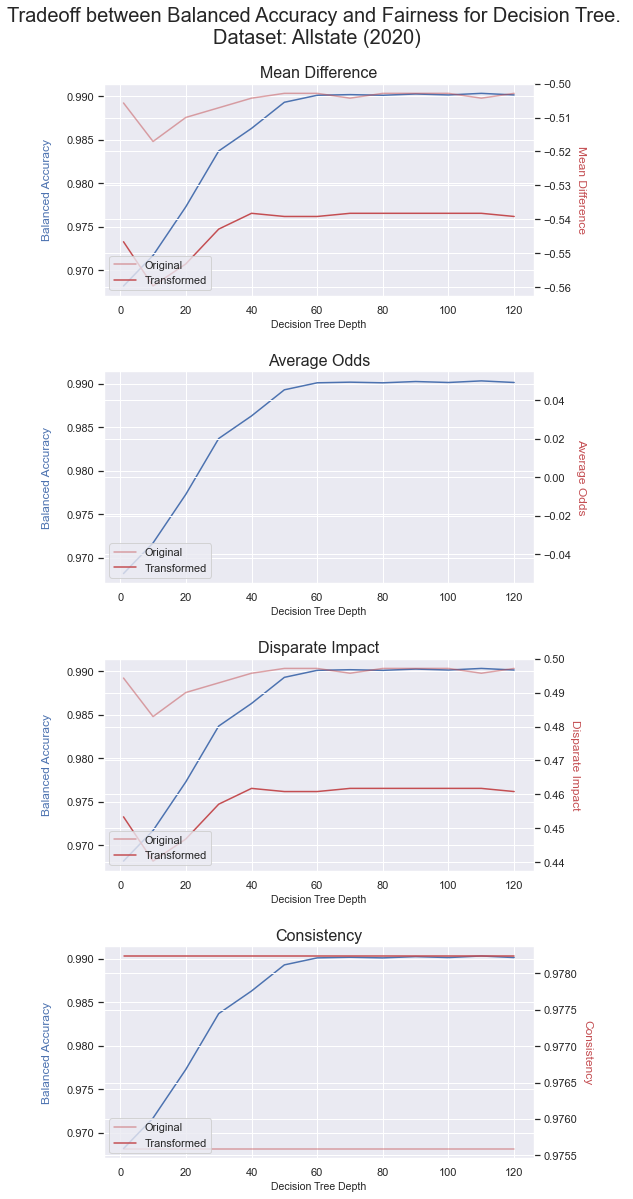

In [80]:
fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(8,16))

plot_tradeoffs(param_arr, bal_acc_arr, mean_diff_arr, mean_diff_arr_transf, ax=ax[0], name='Mean Difference')

plot_tradeoffs(param_arr, bal_acc_arr, avg_odds_arr, avg_odds_arr_transf, ax=ax[1], name='Average Odds')

plot_tradeoffs(param_arr, bal_acc_arr, disp_imp_arr, disp_imp_arr_transf, ax=ax[2], name='Disparate Impact')

plot_tradeoffs(param_arr, bal_acc_arr, indiv_fair_arr, indiv_fair_arr_transf, ax=ax[3], name='Consistency')

fig.tight_layout(h_pad=2, w_pad=2.5)
fig.suptitle('Tradeoff between Balanced Accuracy and Fairness for Decision Tree. \nDataset: Allstate (2020)', 
             x=0.5, y=1.04, size=20)
plt.show()